# DOG BREED CLASSIFICATION

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug
!pip install jinja2==3.0.1 --force-reinstall

!pip install torch #==1.13.1
!pip install torchvision #==0.14.1


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
  Using cached Jinja2-3.0.1-py3-none-any.whl (133 kB)
  Using cached MarkupSafe-2.1.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.1.2
    Uninstalling MarkupSafe-2.1.2:
      Successfully uninstalled MarkupSafe-2.1.2
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 3.1.2
    Uninstalling Jinja2-3.1.2:
      Successfully uninstalled Jinja2-3.1.2

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# TODO: Import any packages that you might need - check: more may be required to be added later
# For instance you will need Boto3 and Sagemaker
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import sagemaker
from sagemaker import get_execution_role, image_uris
import boto3
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.model import Model
from PIL import Image

import tqdm
from jinja2.utils import markupsafe 
from markupsafe import Markup

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

import smdebug
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter, CategoricalParameter
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.predictor import Predictor


/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-04-02 15:29:04.757 pytorch-1-13-cpu-py39-ml-t3-medium-9140905751f3e451a2295c86a7c3:27 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
#TODO: Fetch and upload the data to AWS S3

## Command to download and unzip data
#!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
#!unzip dogImages.zip

In [4]:
# Specify S3 bucket location for data upload - ToDo: check at what level images are and where for upload
session = sagemaker.session.Session()
role = sagemaker.get_execution_role()

#local_dir = 'dogImages' - comment out upload and only re-run in final re-run of project
bucket = 'sagemaker-us-east-1-308298057408'
prefix = 'data/dogImages'

#train_inputs = session.upload_data('./dogImages/train', bucket=bucket, key_prefix=prefix + '/train')
#valid_inputs = session.upload_data('./dogImages/valid', bucket=bucket, key_prefix=prefix + '/valid')
#test_inputs = session.upload_data('./dogImages/test', bucket=bucket, key_prefix=prefix + '/test')

In [5]:
os.environ['SM_CHANNEL_TRAINING']='s3://sagemaker-us-east-1-308298057408/data/dogImages'
os.environ['SM_MODEL_DIR']='s3://sagemaker-us-east-1-308298057408/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://sagemaker-us-east-1-308298057408/output/'

print(os.environ['SM_CHANNEL_TRAINING'])

s3://sagemaker-us-east-1-308298057408/data/dogImages


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [6]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameters = {'epochs': 5 }

hyperparameter_ranges = {
    'lr': ContinuousParameter(0.001,0.1),
    'batch_size': CategoricalParameter([64, 128, 256])
}

objective_metric_name = 'Test Loss'
objective_type = 'Minimize'
metric_definitions = [{'Name': 'Test Loss', 'Regex': 'Testing Loss: ([0-9\\.]+)'}]

In [7]:
#TODO: Create estimators for your HPs - ToDo: confirm some names: check framework and Python version py36?

estimator = PyTorch(
    entry_point='hpo_AG.py',
    base_job_name='dog-images-hpo',
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.xlarge',
    framework_version='1.4.0',
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,
    objective_type=objective_type,
    #early_stopping_type='Auto',
)

In [17]:
# TODO: Fit your HP Tuner - check whether wait=True is more appropriate
tuner.fit({"training": "s3://sagemaker-us-east-1-308298057408/data/dogImages/"}, wait=True)


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..........................................................................................................................................................................................................................................................................................................................!


In [18]:
# TODO: Get the best estimators and the best HPs
best_training_job = tuner.best_training_job()
print('The best training job is: {}'.format(best_training_job))

best_estimator = tuner.best_estimator()
print('The best estimator is: {}'.format(best_estimator))

#Get the hyperparameters of the best trained model
best_hyperparameters = best_estimator.hyperparameters()
print('The best hyperparameters are: {}'.format(best_hyperparameters))

The best training job is: pytorch-training-230330-1706-001-23787e40

2023-03-30 17:20:54 Starting - Preparing the instances for training
2023-03-30 17:20:54 Downloading - Downloading input data
2023-03-30 17:20:54 Training - Training image download completed. Training in progress.
2023-03-30 17:20:54 Uploading - Uploading generated training model
2023-03-30 17:20:54 Completed - Resource reused by training job: pytorch-training-230330-1706-002-a309389f
The best estimator is: <sagemaker.pytorch.estimator.PyTorch object at 0x7f58e32505e0>
The best hyperparameters are: {'_tuning_objective_metric': '"Test Loss"', 'batch_size': '"128"', 'lr': '0.07962265184212618', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"dog-images-hpo-2023-03-30-17-06-14-952"', 'sagemaker_program': '"hpo_AG.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [19]:
# Add best hyperparameters - ToDo: check what we get - add provisional data to see whether we can get rest of code working
best_estimator = tuner.best_estimator()

best_hyperparameters = {
    'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"','')),
    #'epochs': best_estimator.hyperparameters()['epochs'],
    'lr': best_estimator.hyperparameters()['lr'],
}

print('The best hyperparameters are: {}'.format(best_hyperparameters))


2023-03-30 17:20:54 Starting - Preparing the instances for training
2023-03-30 17:20:54 Downloading - Downloading input data
2023-03-30 17:20:54 Training - Training image download completed. Training in progress.
2023-03-30 17:20:54 Uploading - Uploading generated training model
2023-03-30 17:20:54 Completed - Resource reused by training job: pytorch-training-230330-1706-002-a309389f
The best hyperparameters are: {'batch_size': 128, 'lr': '0.07962265184212618'}


In [59]:
# TODO: Set up debugging and profiling rules and hooks: check millis may be shorter (300, 1000)?
rules = [
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization())
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10))

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "5","eval.save_interval": "10"})]

debugger_config=DebuggerHookConfig(collection_configs=collection_configs)


In [60]:
## TODO: Create and fit an estimator: check Python and framework versions
hyperparameters = {'epochs': 10, 'batch_size': 128, 'lr': 0.001, 'eps': 0.00000001, 'momentum': 0.05}

estimator = PyTorch(
    entry_point='train_model_AG.py',
    base_job_name='dog-images-train',
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.xlarge',
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
    framework_version='1.4.0',
    py_version='py3',
)

In [61]:
# Train the model using the best hyperparameters
estimator.fit({"training": "s3://sagemaker-us-east-1-308298057408/data/dogImages/"}, wait=True)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.i

2023-04-02 18:03:29 Starting - Starting the training job...
2023-04-02 18:03:54 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-04-02 18:04:55 Downloading - Downloading input data...
2023-04-02 18:05:22 Training - Downloading the training image......
2023-04-02 18:06:23 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-02 18:06:23,217 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2023-04-02 18:06:23,243 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-02 18:06:23,245 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-02 18:06:

In [62]:
# Get training job details
training_job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=training_job_name)

print(training_job_name)

dog-images-train-2023-04-02-18-03-28-315


In [63]:
# TODO: Plot a debugging output.
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-04-02 18:13:14.687 pytorch-1-13-cpu-py39-ml-t3-medium-9140905751f3e451a2295c86a7c3:27 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-308298057408/dog-images-train-2023-04-02-18-03-28-315/debug-output


In [64]:
trial.tensor_names()

[2023-04-02 18:13:20.068 pytorch-1-13-cpu-py39-ml-t3-medium-9140905751f3e451a2295c86a7c3:27 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-04-02 18:13:21.093 pytorch-1-13-cpu-py39-ml-t3-medium-9140905751f3e451a2295c86a7c3:27 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.3.bias',
 'gradient/ResNet_fc.3.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

#### Use some functions to plot train and eval loss tensors

In [65]:
# Function to get tensor data such as 'CrossEntropyLoss_output_0'
def get_data(trial, trname, mode):
    tensor = trial.tensor(trname)
    steps = tensor.steps(mode=mode)
    values = []
    for i in steps:
        values.append(tensor.value(i, mode=mode))
    return steps, values

In [66]:
# Testing - checking output
train_steps, train_values = get_data(trial, 'CrossEntropyLoss_output_0', mode=ModeKeys.TRAIN)
eval_steps, eval_values = get_data(trial, 'CrossEntropyLoss_output_0', mode=ModeKeys.EVAL)

# Print the number of recorded steps for training and validation loss function
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

26
3


completed TRAIN plot
completed EVAL plot


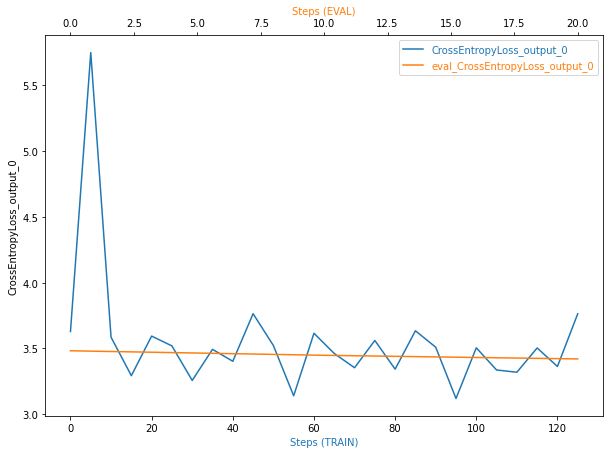

<Figure size 432x288 with 0 Axes>

In [67]:
# Plot the CrossEntropyLosses for training and validation data
tensor_name = 'CrossEntropyLoss_output_0'

fig = plt.figure(figsize=(10, 7))
host = host_subplot(111)

par = host.twiny()

host.set_xlabel("Steps (TRAIN)")
par.set_xlabel("Steps (EVAL)")
host.set_ylabel(tensor_name)

(p1,) = host.plot(train_steps, train_values, label=tensor_name)
print("completed TRAIN plot")
(p2,) = par.plot(eval_steps, eval_values, label="eval_" + tensor_name)
print("completed EVAL plot")
leg = plt.legend()

host.xaxis.get_label().set_color(p1.get_color())
leg.texts[0].set_color(p1.get_color())

par.xaxis.get_label().set_color(p2.get_color())
leg.texts[1].set_color(p2.get_color())

plt.ylabel(tensor_name)
    
plt.show()
plt.savefig('screenshots/crossentropy_losses.png')

Current issues in above output: loss not decreasing 



**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [68]:
region = "us-east-1"

trainj = TrainingJob(training_job_name, region)
trainj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-308298057408/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-308298057408/dog-images-train-2023-04-02-18-03-28-315/profiler-output


Profiler data from system is available


In [69]:
# Get the name of the profiler report to add to full path below
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

print(profiler_report_name)

ProfilerReport


In [70]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + '/rule_output/'

profiler_output_path = rule_output_path + profiler_report_name + "/profiler_output/"

print(f'The profiler report is located here: {profiler_output_path}profiler-report.html')

The profiler report is located here: s3://sagemaker-us-east-1-308298057408/dog-images-train-2023-04-02-18-03-28-315/rule_output/ProfilerReport/profiler_output/profiler-report.html


In [71]:
# List profiler report rule output path
! aws s3 ls {rule_output_path} --recursive

In [72]:
# Copy to local
! aws s3 cp {rule_output_path} . --recursive

## Model Deploying

In [24]:
model_location=estimator.model_data
print(model_location)

s3://sagemaker-us-east-1-308298057408/dog-images-train-2023-03-31-19-39-47-470/output/model.tar.gz


In [25]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [26]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [27]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


INFO:sagemaker:Creating model with name: pytorch-inference-2023-03-31-19-59-16-704
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-03-31-19-59-17-548
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-03-31-19-59-17-548


------!

In [28]:
# Predict image class using image url
import requests
request_dict1={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
request_dict2={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

img1_bytes = requests.get(request_dict1['url']).content
img2_bytes = requests.get(request_dict2['url']).content


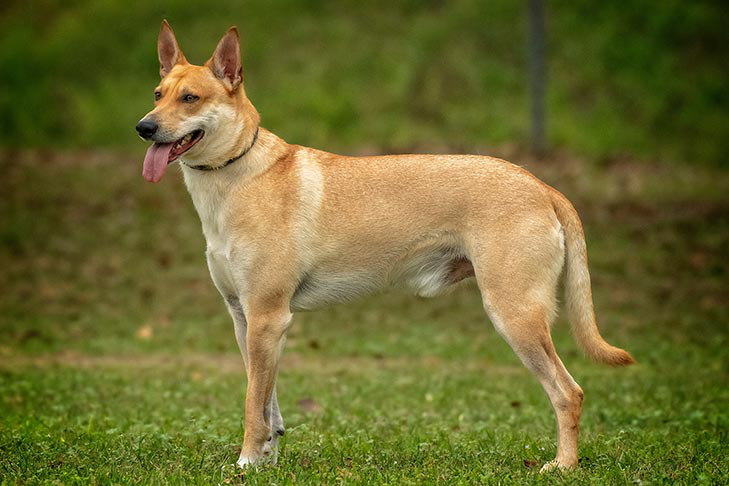

In [29]:
from PIL import Image
import io
Image.open(io.BytesIO(img1_bytes)) 
Image.open(io.BytesIO(img2_bytes))

In [30]:
response1=predictor.predict(img1_bytes, initial_args={"ContentType": "image/jpeg"})

pred1_class = np.argmax(response1, 1) + 1
print(pred1_class)


[5]


In [31]:
response2=predictor.predict(img2_bytes, initial_args={"ContentType": "image/jpeg"})

pred2_class = np.argmax(response2, 1) + 1
print(pred2_class)


[5]


#### Test using local test images

In [ ]:
# To be deleted: this step can be removed as images in final code run are expected to be available locally as well as on S3
! aws s3 cp s3://sagemaker-us-east-1-308298057408/data/dogImages/test/  dogImages/test/ --recursive


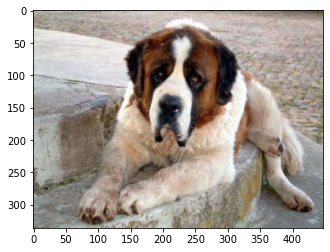

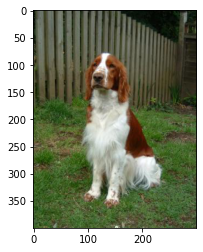

In [37]:
# Predict dog breed using locally saved images
test_img1 = plt.imread('./dogImages/test/126.Saint_bernard/Saint_bernard_08020.jpg')

test_img2 = plt.imread('./dogImages/test/130.Welsh_springer_spaniel/Welsh_springer_spaniel_08215.jpg')
plt.imshow(test_img1)
plt.show()
plt.imshow(test_img2)
plt.show()

In [38]:
image1_path = './dogImages/test/126.Saint_bernard/Saint_bernard_08020.jpg'
image1_class = "126"

with open(image1_path, "rb") as f:
    payload = f.read()
    
    response1=predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
    pred1_class = np.argmax(response1, 1) + 1
    print(pred1_class)
 

[5]


In [39]:
image2_path = './dogImages/test/130.Welsh_springer_spaniel/Welsh_springer_spaniel_08215.jpg'
image2_class = "130"

with open(image2_path, "rb") as f:
    payload = f.read()
    
    response2=predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
    pred2_class = np.argmax(response2, 1) + 1
    print(pred2_class)
 

[5]


#### Delete Endpoint

In [40]:
# TODO: Remember to shutdown/delete your endpoint once your work is done - manual shutdown of endpoint but this cell works as well
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-03-31-19-59-17-548
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-03-31-19-59-17-548
